In [0]:
!pip3 install torch torchvision
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

In [0]:
data = pd.read_csv('fer2013.csv')


In [0]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
width, height = 48, 48

images = []
lables = []
for index,row in data.iterrows():
    pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
    img=pixels.reshape((width,height))
    images.append(img)
    lables.append(row['emotion'])

In [0]:
print(len(lables))


35887


In [0]:
width, height = 48, 48

train_images = []
test_images = []
train_labels = []
test_labels = []
train_data = []
test_data = []
for index,row in data.iterrows():
    pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
    img=pixels.reshape((width,height))
    if row['Usage'] == 'Training':
      train_labels.append(row['emotion'])
      train_images.append(img)
      train_data.append(img)
      #train_data.append(row['emotion'])
    else :
      test_labels.append(row['emotion'])
      test_images.append(img)
      test_data.append(img)
      #test_data.append(row['emotion'])

for index,row in data.iterrows():
  if row['Usage'] == 'Training':
    train_data.append(row['emotion'])
  else :
    test_data.append(row['emotion'])

In [0]:

BATCH_SIZE = 256

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
    
        if self.transform:
            #x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

    def __iter__(self):
        return self

transform = transforms.Compose([transforms.ToTensor()])



In [0]:
trainset = MyDataset(train_images,train_labels, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE)#, shuffle=True, num_workers=2)

In [0]:
testset = MyDataset(test_images, test_labels, transform=transform)

testloader = DataLoader(testset, batch_size=BATCH_SIZE)#, shuffle=False, num_workers=2)

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [0]:
len(images)

256

In [0]:
def imshow(img):
    #img = img / 2 + 0.5     
    npimg = img.numpy()
    print(npimg.shape)
    print(np.transpose(npimg).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

(3, 1602, 402)
(402, 1602, 3)


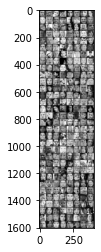

In [0]:
imshow(torchvision.utils.make_grid(images))

In [0]:
# parameters 
N_STEPS = 48
N_INPUTS = 48
N_NEURONS = 100
N_OUTPUTS = 7
N_EPHOCS = 10000

In [0]:
class ImageRNN(nn.Module):
    
    # declaraction of variables
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
    
    # initialize hidden weights that have zero values
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        # lstm_out => n_steps, batch_size, n_neurons (hidden states for each time step)
        # self.hidden => 1, batch_size, n_neurons (final state from each lstm_out)
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [0]:
# Testing the model
      
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 48,48))
print(logits[0:10])

tensor([[-0.1362, -0.3731,  0.0525, -0.0705,  0.2559,  0.2967, -0.0587],
        [-0.1548, -0.2835,  0.0944, -0.0590,  0.2852,  0.3740, -0.0506],
        [-0.1733, -0.3123,  0.1451, -0.0846,  0.3252,  0.4219, -0.0567],
        [-0.1871, -0.3251,  0.0267, -0.0909,  0.3087,  0.3941, -0.1491],
        [-0.0292, -0.2067,  0.0520, -0.0125,  0.0547,  0.0831, -0.0649],
        [-0.1078, -0.3425,  0.0498, -0.0621,  0.1448,  0.2845, -0.1660],
        [-0.1124, -0.1720,  0.0424,  0.0154,  0.1252,  0.2443, -0.0152],
        [-0.1580, -0.3465,  0.0230, -0.0698,  0.2528,  0.2534, -0.1003],
        [-0.1240, -0.3108,  0.0597, -0.0775,  0.2415,  0.3229, -0.2047],
        [-0.2307, -0.2645,  0.0949, -0.0960,  0.4196,  0.4385,  0.0129]],
       grad_fn=<SliceBackward>)


In [0]:
# Training the model
   
import torch.optim as optim

# Device: you can choose what device that you want to use during the training process
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [0]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 48,48) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' 
         %(epoch, train_running_loss/i, train_acc/i))
# print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' 
#           %(epoch, train_running_loss/i, train_acc/i))    


# TEST ACCURACY
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 48, 48)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%(test_acc / i))


In [0]:
# transform = transforms.Compose([transforms.ToTensor()])
# class Transform():
#     def __init__(self, images, transform=None):
#         self.images = images
#         # self.targets = torch.LongTensor(targets)
#         self.transform = transform
# #trainset_images = MyDataset(train_images, transform=transform)
# trainset_images = 
# trainloader_images = DataLoader(trainset_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [0]:
# testset_images = MyDataset(test_images, transform=transform)
# testloader_images = DataLoader(testset_images, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [0]:
# print(len(train_images))
# print(len(test_images))
# print(len(train_labels))
# print(len(test_labels))
# #train_images

In [0]:
# print(len(trainset))
# print(len(trainloader))
# print(len(testset))
# print(len(testloader))


In [0]:
# print(len(trainset_images))
# print(len(trainloader_images))
# print(len(testset_images))
# print(len(testloader_images))

In [0]:
# import matplotlib.pyplot as plt
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# labels.shape

In [0]:
# import torch
# import numpy as np
# from torch.utils import data

# tensor_x = torch.Tensor(train_images)
# tensor_y = torch.Tensor(train_labels)


In [0]:
# tensor_x.shape
# tensor_x.view(-1,48,48)
 #import matplotlib.pyplot as plt

In [0]:
# functions to show an image
#def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    
 #   plt.imshow(img,(48,48))


In [0]:
#imshow(train_images[0][0])

In [0]:
#train_images = np.array(train_images)
#train_images.shape

In [0]:
# from PIL import Image
# import numpy as np

# w, h = 48, 48
# img = Image.fromarray(train_images[0][0], 'RGB')
# img.save('my.png')
# img.show()


